In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/test/8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2100032a-7c33-4bff-97ef-690822c43466.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2f392438-e215-4169-bebf-21ac4ff253e1.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/3f316b38-1a24-45a9-8d8c-4e05a42257c6.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/f8b03c87-9d1a-4f20-b76b-cb6c69d447b2.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/585ba241-6348-41ce-a5d2-c9ee434cd64d.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/bde73ad6-ce46-489b-8ee0-b162698cc6df.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/c7ce1ac6-36e4-4258-b2e4-1b525dc82ad5.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/9d75e205-3030-44c6-ae

# Notebooks that I Adapted:

* https://www.kaggle.com/dineshkumaranbalagan/descriptive-analysis

* https://www.kaggle.com/mlconsult/score-57ish-with-additional-govt-datasets

* https://www.kaggle.com/adnaiksachin25/wordcloud-cosine-jaccard-sequencematcher

* https://www.kaggle.com/ht5brer/difference-between-appearing-and-mentioning

* https://www.kaggle.com/armandmorin/show-us-data


# Introduction

## Goal

* The end goal is to do string matching of known datasets names in order to detect mentions of datasets in scientific publications.
* To build a strong NLP model that can infer from context whether or not a piece of text in a publication is refering to the usage of a dataset or not.

# Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial
from tqdm.autonotebook import tqdm
import string

from PIL import Image

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000
from spacy.util import compounding
from spacy.util import minibatch

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Description

         - train.csv- CSV file contains metadata of the publications
         - train-JSON file contains publications that are referenced in train.csv
         - test-CSV file contains publications for testing purpose
         - sample_submission.csv-CSV file conatins publications IDs column and prediction columns

**id** - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.

**pub_title** -title of the publication (a small number of publications have the same title).

**dataset_title** -the title of the dataset that is mentioned within the publication.

**dataset_label** -a portion of the text that indicates the dataset.

**cleaned_label** -the dataset_label, as passed through the clean_text function from the Evaluation page.

**PredictionString** -To be filled with equivalent of cleaned_label of train data

# OBTAIN

### Train Set

In [3]:
#define paths
os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')
train_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [4]:
#read train data
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [5]:
#create a function to get the text from the JSON file and append it to the new column in table
def read_json_pub(filename, train_path = train_path, output = 'text'):
    json_path = os.path.join(train_path, (filename + '.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [6]:
#apply the function to train data
tqdm.pandas()
train_df['text'] = train_df['Id'].progress_apply(read_json_pub)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [7]:
#recheck
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth,..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1. Accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This article investigates an important factor ...


### Read Submission Data

In [8]:
#read submission data
submission_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')

#apply the function to submission data
tqdm.pandas()
submission_df['text'] = submission_df['Id'].progress_apply(read_json_pub)

submission_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


In [9]:
#save
submission_df.to_csv('submission_df.csv')

### Read Samples

In [10]:
#let's read the first sample

import json
with open('../input/coleridgeinitiative-show-us-the-data/train/d0fa7568-7d8e-4db9-870f-f9c6f668c17b.json') as f:
    sample = json.load(f)
    
sample

[{'section_title': 'What is this study about?',
  'text': 'This study used data from the National Education Longitudinal Study (NELS:88) to examine the effects of dual enrollment programs for high school students on college degree attainment. The study also reported whether the impacts of dual enrollment programs were different for first generation college students versus students whose parents had attended at least some college. In addition, a supplemental analysis reports on the impact of different amounts of dual enrollment course-taking and college degree attainment.\nDual enrollment programs offer college-level learning experiences for high school students. The programs offer college courses and/or the opportunity to earn college credits for students while still in high school.\nThe intervention group in the study was comprised of NELS participants who attended a postsecondary school and who participated in a dual enrollment program while in high school (n = 880). The study author

In [11]:
#get all 'section_title'
for s in sample:
    print(s['section_title'])

What is this study about?
Features of Dual Enrollment Programs
WWC Single Study Review
WWC Rating
Intervention group
Comparison group
Outcomes and measurement
Support for implementation
Reason for review
Degree attainment
Bachelor's degree attainment
Study Notes:
Glossary of Terms
Multiple comparison adjustment
Quasi-experimental design (QED)
Randomized controlled trial (RCT)
Single-case design (SCD)
Standard deviation


In [12]:
with open('../input/coleridgeinitiative-show-us-the-data/train/2f26f645-3dec-485d-b68d-f013c9e05e60.json') as f:
    sample = json.load(f)
    
sample[:2]

[{'section_title': 'November 2004',
  'text': "Dropping out of high school is not necessarily the end of a student's formal education. Some students who drop out return a short time later to earn a diploma, some may pursue an alternative credential such as a General Educational Development (GED) certificate, and others may enroll in a postsecondary institution without having earned a high school credential. Using data on public and private school students from the National Education Longitudinal Study of 1988 (NELS:88), Berktold, Geis, and Kaufman (1998) examined the educational attainment of the 21 percent of 1988 eighth-graders who had dropped out of high school at least once between eighth grade and the spring of 1994, 2 years after they would have graduated if they had finished with the majority of their cohort.\n1 They found that about 44 percent of these dropouts had received a high school diploma or an alternative high school credential by 1994. Of the 56 percent of all dropouts

In [13]:
#get all 'section_title'
for s in sample:
    print(s['section_title'])

November 2004
2,3
Defining Dropouts
4
High School Completion Status
5
Postsecondary Experience of Dropouts
Summary
Endnotes


# SCRUB

### Basic Text Cleaning

Before we can create a bag of words or vectorize each document, we need to clean it up and split each document into an array of individual words. Computers are very particular about strings. If we tokenized our data in its current state, we would run into the following problems:

* Counting things that aren't actually words. 
* Punctuation and capitalization would mess up our word counts. We need to remove punctuation and capitalization, so that all words will be counted correctly.

In [14]:
def text_cleaning(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    text = re.sub(' +', ' ', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [15]:
#clean train text
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(text_cleaning)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [16]:
#review
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this study used data from the national educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,stress satisfactory outcomes for all youth inc...
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,federal reserve bank of richmond s1 accounting...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this article investigates an important factor ...


In [17]:
#save
train_df.to_csv('train_df.csv')

### Basic Tokenization & Remove StopWords

In [18]:
#define stopwords

from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [19]:
#tokenize each word in each articles

def process_article(article):
    
    """Take in one parameter, article
       Tokenize the article using the appropriate function from nltk
       Lowercase every token, remove any stopwords found in stopwords_list from the tokenized article, and return the results"""
    
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [20]:
#remove stopwords
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(process_article)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [21]:
#review
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,"[study, used, data, national, education, longi..."
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,"[dropping, high, school, necessarily, end, stu..."
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,"[stress, satisfactory, outcomes, youth, includ..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,"[federal, reserve, bank, richmond, s1, account..."
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,"[article, investigates, important, factor, stu..."


In [22]:
#save
train_df.to_csv('preprocessed_train_df.csv')

# EXPLORE

In [23]:
#get info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
 5   text           19661 non-null  object
dtypes: object(6)
memory usage: 921.7+ KB


In [24]:
#check null values
train_df.isnull().sum()

Id               0
pub_title        0
dataset_title    0
dataset_label    0
cleaned_label    0
text             0
dtype: int64

In [25]:
#get summary
train_df.describe()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
count,19661,19661,19661,19661,19661,19661
unique,14316,14271,45,130,130,14301
top,170113f9-399c-489e-ab53-2faf5c64c5bc,Science and Engineering Indicators 2014,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,"[national, science, foundation, 20, 14, nation..."
freq,22,22,6144,3673,3673,22


The Train dataset has 19,661 counts but only 14,316 unique 'Id' in the dataset. This means some 'Id' are duplicates, meaning some 'Id' use multiple datasets.

The 'pub_title' has 19,661 counts but has only 14,271 unique titles. This means some 'pub_titles' are duplicates. There are less 'pub_title' counts than 'Id' counts, meaning some 'pub_title' has multiple 'Id'.

The 'dataset_title' has 19,661 counts but has only 45 unique titles. This means some 'dataset_title' are used many times by different publications.

The 'dataset_label' has 19,661 counts but has only 130 unique labels. This means some 'dataset_label' are duplicates. There are less 'dataset_title' counts than 'dataset_label', meaning some 'dataset_title' are labeled differently by different publications.

In [26]:
print('Number of duplicates in Id:', train_df['Id'].duplicated().sum())
print('Number of duplicates in pub_title:', train_df['pub_title'].duplicated().sum())
print('Number of duplicates in dataset_title:', train_df['dataset_title'].duplicated().sum())
print('Number of duplicates in dataset_label:', train_df['dataset_label'].duplicated().sum())
print('Number of duplicates in cleaned_label:', train_df['cleaned_label'].duplicated().sum())

Number of duplicates in Id: 5345
Number of duplicates in pub_title: 5390
Number of duplicates in dataset_title: 19616
Number of duplicates in dataset_label: 19531
Number of duplicates in cleaned_label: 19531


In [27]:
#check out duplicates
id_duplicates = train_df['Id'] == 'c754dec7-c5a3-4337-9892-c02158475064'
train_df.loc[id_duplicates][:5]

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,"[article, investigates, important, factor, stu..."
8121,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",Education Longitudinal Study,Education Longitudinal Study,education longitudinal study,"[article, investigates, important, factor, stu..."


The same 'Id' and 'pub_title' of sample 4 and 8121 are labeled differently as 'National Education Longitudinal Study' and 'Education Longitudinal Study' although they are the same publication.

In [28]:
#check out duplicates
pub_title_duplicates = train_df['pub_title'] == 'Science and Engineering Indicators 2014'
train_df.loc[pub_title_duplicates][:5]

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
14795,170113f9-399c-489e-ab53-2faf5c64c5bc,Science and Engineering Indicators 2014,Beginning Postsecondary Student,Beginning Postsecondary Students Longitudinal ...,beginning postsecondary students longitudinal ...,"[national, science, foundation, 20, 14, nation..."
14796,170113f9-399c-489e-ab53-2faf5c64c5bc,Science and Engineering Indicators 2014,Survey of Science and Engineering Research Fac...,National Science Foundation Survey of Science ...,national science foundation survey of science ...,"[national, science, foundation, 20, 14, nation..."
14797,170113f9-399c-489e-ab53-2faf5c64c5bc,Science and Engineering Indicators 2014,Higher Education Research and Development Survey,National Science Foundation Higher Education R...,national science foundation higher education r...,"[national, science, foundation, 20, 14, nation..."
14798,170113f9-399c-489e-ab53-2faf5c64c5bc,Science and Engineering Indicators 2014,Survey of Earned Doctorates,Survey of Earned Doctorates,survey of earned doctorates,"[national, science, foundation, 20, 14, nation..."
14799,170113f9-399c-489e-ab53-2faf5c64c5bc,Science and Engineering Indicators 2014,Survey of Earned Doctorates,National Center for Science and Engineering St...,national center for science and engineering st...,"[national, science, foundation, 20, 14, nation..."


When check out pub_title_duplicates, we see that there are same 'text' with same 'Id' and same 'pub_title' but labeled different i.e 14798 and 14799 dataset_title of 'Survey of Earned Doctorates' are labeled as 'Survey of Earned Doctorates' and 'National Center for Science and Engineering...'

In [29]:
#check out duplicates
dataset_title_duplicates = train_df['dataset_title'] == "Higher Education Research and Development Survey"
train_df.loc[dataset_title_duplicates][:5]

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
1450,aa434be4-4725-4920-ad79-170efec7c527,Research Funding,Higher Education Research and Development Survey,NSF Higher Education Research and Development ...,nsf higher education research and development ...,"[importance, research, higher, education, scie..."
12456,aa434be4-4725-4920-ad79-170efec7c527,Research Funding,Higher Education Research and Development Survey,Higher Education Research and Development Survey,higher education research and development survey,"[importance, research, higher, education, scie..."
12457,3a0c14ec-279a-4d83-8f32-fe1dcb1dc561,The hunt for the lesser-known funding source,Higher Education Research and Development Survey,Higher Education Research and Development Survey,higher education research and development survey,"[podcast, tech, revolution, lab, go, nature, c..."
14797,170113f9-399c-489e-ab53-2faf5c64c5bc,Science and Engineering Indicators 2014,Higher Education Research and Development Survey,National Science Foundation Higher Education R...,national science foundation higher education r...,"[national, science, foundation, 20, 14, nation..."
14811,170113f9-399c-489e-ab53-2faf5c64c5bc,Science and Engineering Indicators 2014,Higher Education Research and Development Survey,National Center for Science and Engineering St...,national center for science and engineering st...,"[national, science, foundation, 20, 14, nation..."


Here we see with samples 1450 and 12456, there are same 'text' with same 'Id' and same 'pub_title' but labeled different.

## Look At Each Feature Individually

### 'Id'

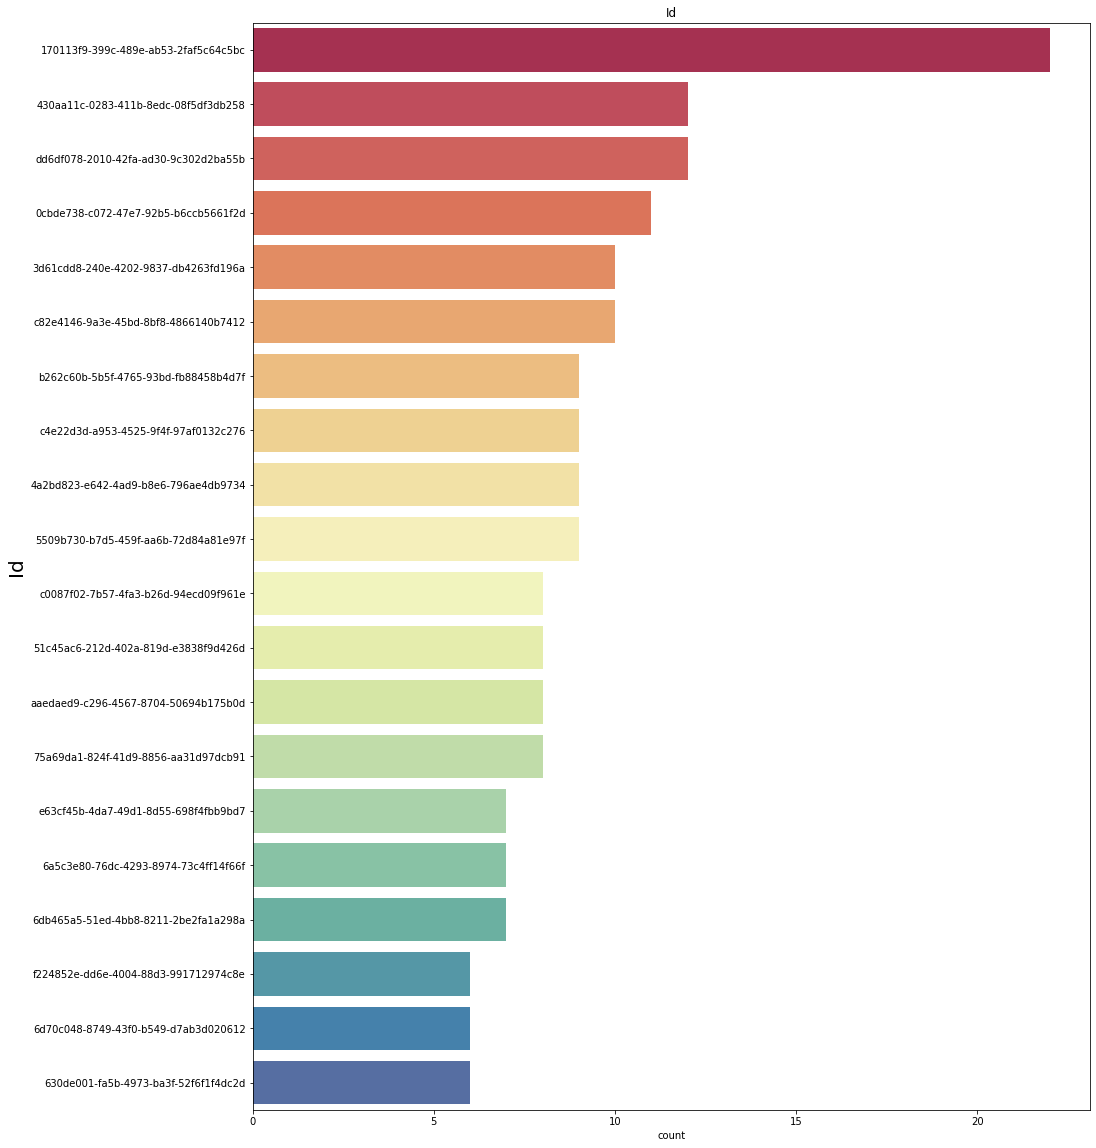

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize = (15, 20)),

sns.countplot(y = train_df['Id'], 
              order = train_df['Id'].value_counts(ascending = False)[:20].index, 
              palette = 'Spectral')
plt.ylabel('Id',fontsize = 20)
plt.title('Id')
plt.show()

#save
plt.savefig('Id.png')

### 'pub_title'

In [31]:
train_df['pub_title'].unique()

array(['The Impact of Dual Enrollment on College Degree Attainment: Do Low-SES Students Benefit?',
       'Educational Attainment of High School Dropouts 8 Years Later. Issue Brief. NCES 2005-026.',
       'Differences in Outcomes for Female and Male Students in Special Education',
       ...,
       'MCCS: a novel recognition pattern-based method for fast track discovery of anti-SARS-CoV-2 drugs',
       'Quantitative Structure–Activity Relationship Machine Learning Models and their Applications for Identifying Viral 3CLpro- and RdRp-Targeting Compounds as Potential Therapeutics for COVID-19 and Related Viral Infections',
       'A ligand-based computational drug repurposing pipeline using KNIME and Programmatic Data Access: case studies for rare diseases and COVID-19'],
      dtype=object)

In [32]:
train_df['pub_title'].value_counts().head(10)

Science and Engineering Indicators 2014                                                                                                            22
 Digest of Education Statistics, 2012 NCES 2014-015 [Appendix A: Guide to Sources; Appendix B: Definitions; Appendix C: Index of Table Numbers]    12
Science and Engineering Indicators 2008                                                                                                            12
 Science and Engineering Indicators 2010                                                                                                           11
Programs and Plans of the National Center for Education Statistics. 2002 Edition.                                                                  10
Programs and Plans of the National Center for Education Statistics. 2003 Edition.                                                                  10
Programs and Plans of the National Center for Education Statistics. 2001 Edition.                   

In [33]:
#create a frequency distribution to see which words are used the most
words = list( train_df['pub_title'].values)
stopwords = stopwords_list
split_words = []

for word in words:
    lo_w = []
    list_of_words = str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []

for wordlist in split_words:
    allwords += wordlist
    
#get 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
mostcommon

[('The', 2133),
 ('A', 1984),
 ('disease', 1424),
 ("Alzheimer's", 1260),
 ('Disease', 1170),
 ('Alzheimer’s', 1123),
 ('Study', 804),
 ('Analysis', 758),
 ('Longitudinal', 748),
 ('Education', 746),
 ('School', 713),
 ('Cognitive', 698),
 ('Data', 661),
 ('cognitive', 659),
 ('brain', 583),
 ('Brain', 581),
 ('using', 576),
 ('Using', 566),
 ('An', 547),
 ('National', 504),
 ('COVID-19', 502),
 ('SARS-CoV-2', 499),
 ('study', 498),
 ('Learning', 495),
 ('analysis', 480),
 ('MRI', 445),
 ('Science', 437),
 ('data', 434),
 ('NCES', 403),
 ('United', 394),
 ('Students', 383),
 ('Mild', 378),
 ('Student', 372),
 ('Early', 355),
 ('Postsecondary', 353),
 ('mild', 353),
 ('Impairment', 352),
 ('Effects', 348),
 ('Alzheimer', 343),
 ('impairment', 334),
 ('US', 316),
 ('High', 314),
 ('Report.', 309),
 ('Research', 305),
 ('College', 300),
 ('U.S.', 299),
 ('States', 296),
 ('among', 293),
 ('Achievement', 292),
 ('imaging', 290),
 ('associated', 285),
 ('Model', 278),
 ('Development', 278),

### 'dataset_title'

In [34]:
train_df['dataset_title'].unique()

array(['National Education Longitudinal Study', 'NOAA Tide Gauge',
       'Sea, Lake, and Overland Surges from Hurricanes',
       'Coastal Change Analysis Program',
       'Aging Integrated Database (AGID)',
       "Alzheimer's Disease Neuroimaging Initiative (ADNI)",
       'Baltimore Longitudinal Study of Aging (BLSA)',
       'Agricultural Resource Management Survey',
       'Beginning Postsecondary Student',
       "The National Institute on Aging Genetics of Alzheimer's Disease Data Storage Site (NIAGADS)",
       'Common Core of Data',
       'Survey of Industrial Research and Development',
       'Baccalaureate and Beyond',
       'International Best Track Archive for Climate Stewardship',
       'National Teacher and Principal Survey',
       'Higher Education Research and Development Survey',
       'Survey of Earned Doctorates', 'School Survey on Crime and Safety',
       'World Ocean Database',
       'Program for the International Assessment of Adult Competencies',
       

In [35]:
train_df['dataset_title'].value_counts().head(20)

Alzheimer's Disease Neuroimaging Initiative (ADNI)          6144
Baltimore Longitudinal Study of Aging (BLSA)                1589
Trends in International Mathematics and Science Study       1163
Early Childhood Longitudinal Study                          1011
SARS-CoV-2 genome sequence                                   860
Census of Agriculture                                        743
Education Longitudinal Study                                 676
Agricultural Resource Management Survey                      660
North American Breeding Bird Survey (BBS)                    585
National Education Longitudinal Study                        550
Survey of Earned Doctorates                                  509
Rural-Urban Continuum Codes                                  490
Beginning Postsecondary Student                              461
NOAA Tide Gauge                                              441
International Best Track Archive for Climate Stewardship     386
Common Core of Data      

In [36]:
#create a frequency distribution to see which words are used the most
words = list( train_df['dataset_title'].values)
stopwords = stopwords_list
split_words = []

for word in words:
    lo_w = []
    list_of_words = str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []

for wordlist in split_words:
    allwords += wordlist
    
#get 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
mostcommon

[('Disease', 6176),
 ("Alzheimer's", 6166),
 ('Neuroimaging', 6144),
 ('Initiative', 6144),
 ('(ADNI)', 6144),
 ('Study', 5081),
 ('Longitudinal', 3918),
 ('Survey', 2378),
 ('International', 1618),
 ('Aging', 1614),
 ('Baltimore', 1589),
 ('(BLSA)', 1589),
 ('Education', 1392),
 ('Science', 1267),
 ('Trends', 1163),
 ('Mathematics', 1163),
 ('Early', 1011),
 ('Childhood', 1011),
 ('SARS-CoV-2', 860),
 ('genome', 860),
 ('sequence', 860),
 ('National', 763),
 ('Census', 743),
 ('Agriculture', 743),
 ('Agricultural', 660),
 ('Resource', 660),
 ('Management', 660),
 ('Data', 651),
 ('North', 585),
 ('American', 585),
 ('Breeding', 585),
 ('Bird', 585),
 ('(BBS)', 585),
 ('World', 549),
 ('Earned', 509),
 ('Doctorates', 509),
 ('Rural-Urban', 490),
 ('Continuum', 490),
 ('Codes', 490),
 ('COVID-19', 490),
 ('Beginning', 461),
 ('Postsecondary', 461),
 ('Student', 461),
 ('NOAA', 441),
 ('Tide', 441),
 ('Gauge', 441),
 ('Program', 391),
 ('Best', 386),
 ('Track', 386),
 ('Archive', 386),
 

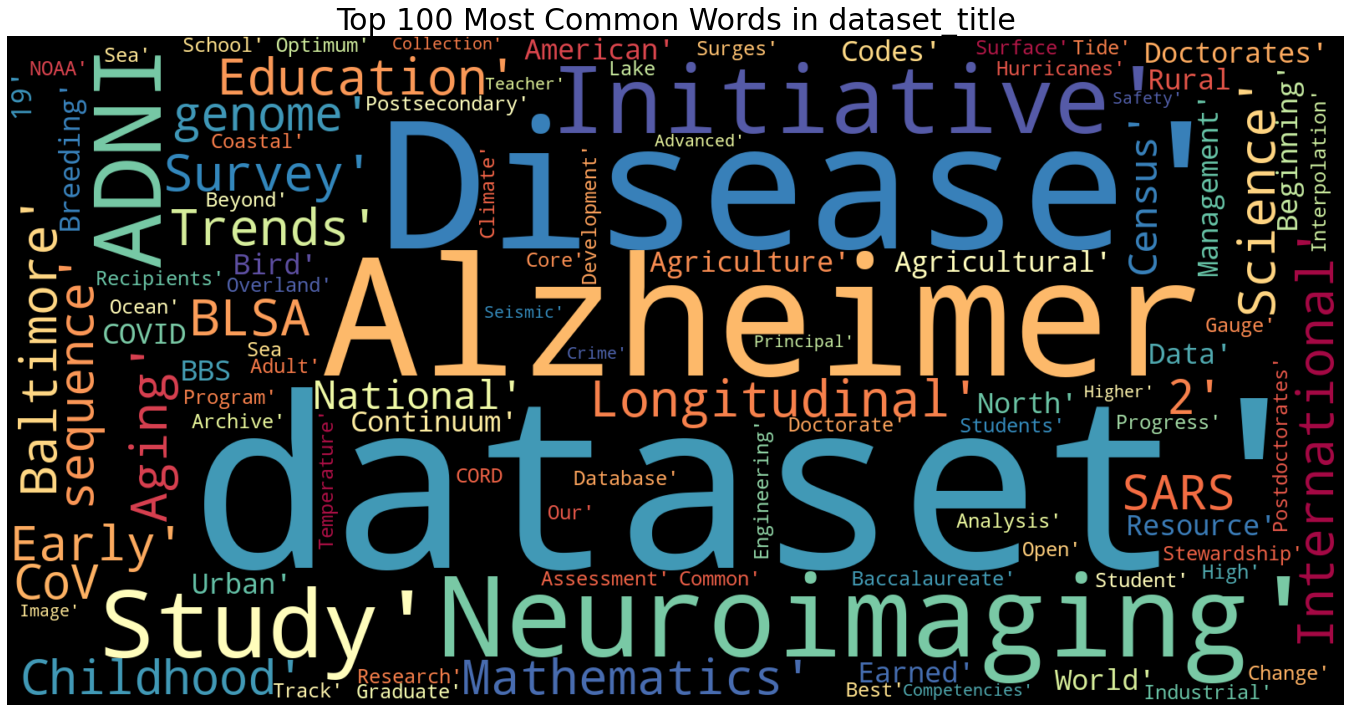

In [37]:
#plot frequency distributions
wordcloud = WordCloud(width = 1600, height = 800, 
                      background_color = 'black', 
                      colormap = 'Spectral', 
                      stopwords = stopwords_list).generate(str(mostcommon))

fig = plt.figure(figsize = (20, 10), facecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 100 Most Common Words in dataset_title', fontsize = 30)
plt.tight_layout()

#save
plt.savefig('dataset_title_top100_common_words.png')

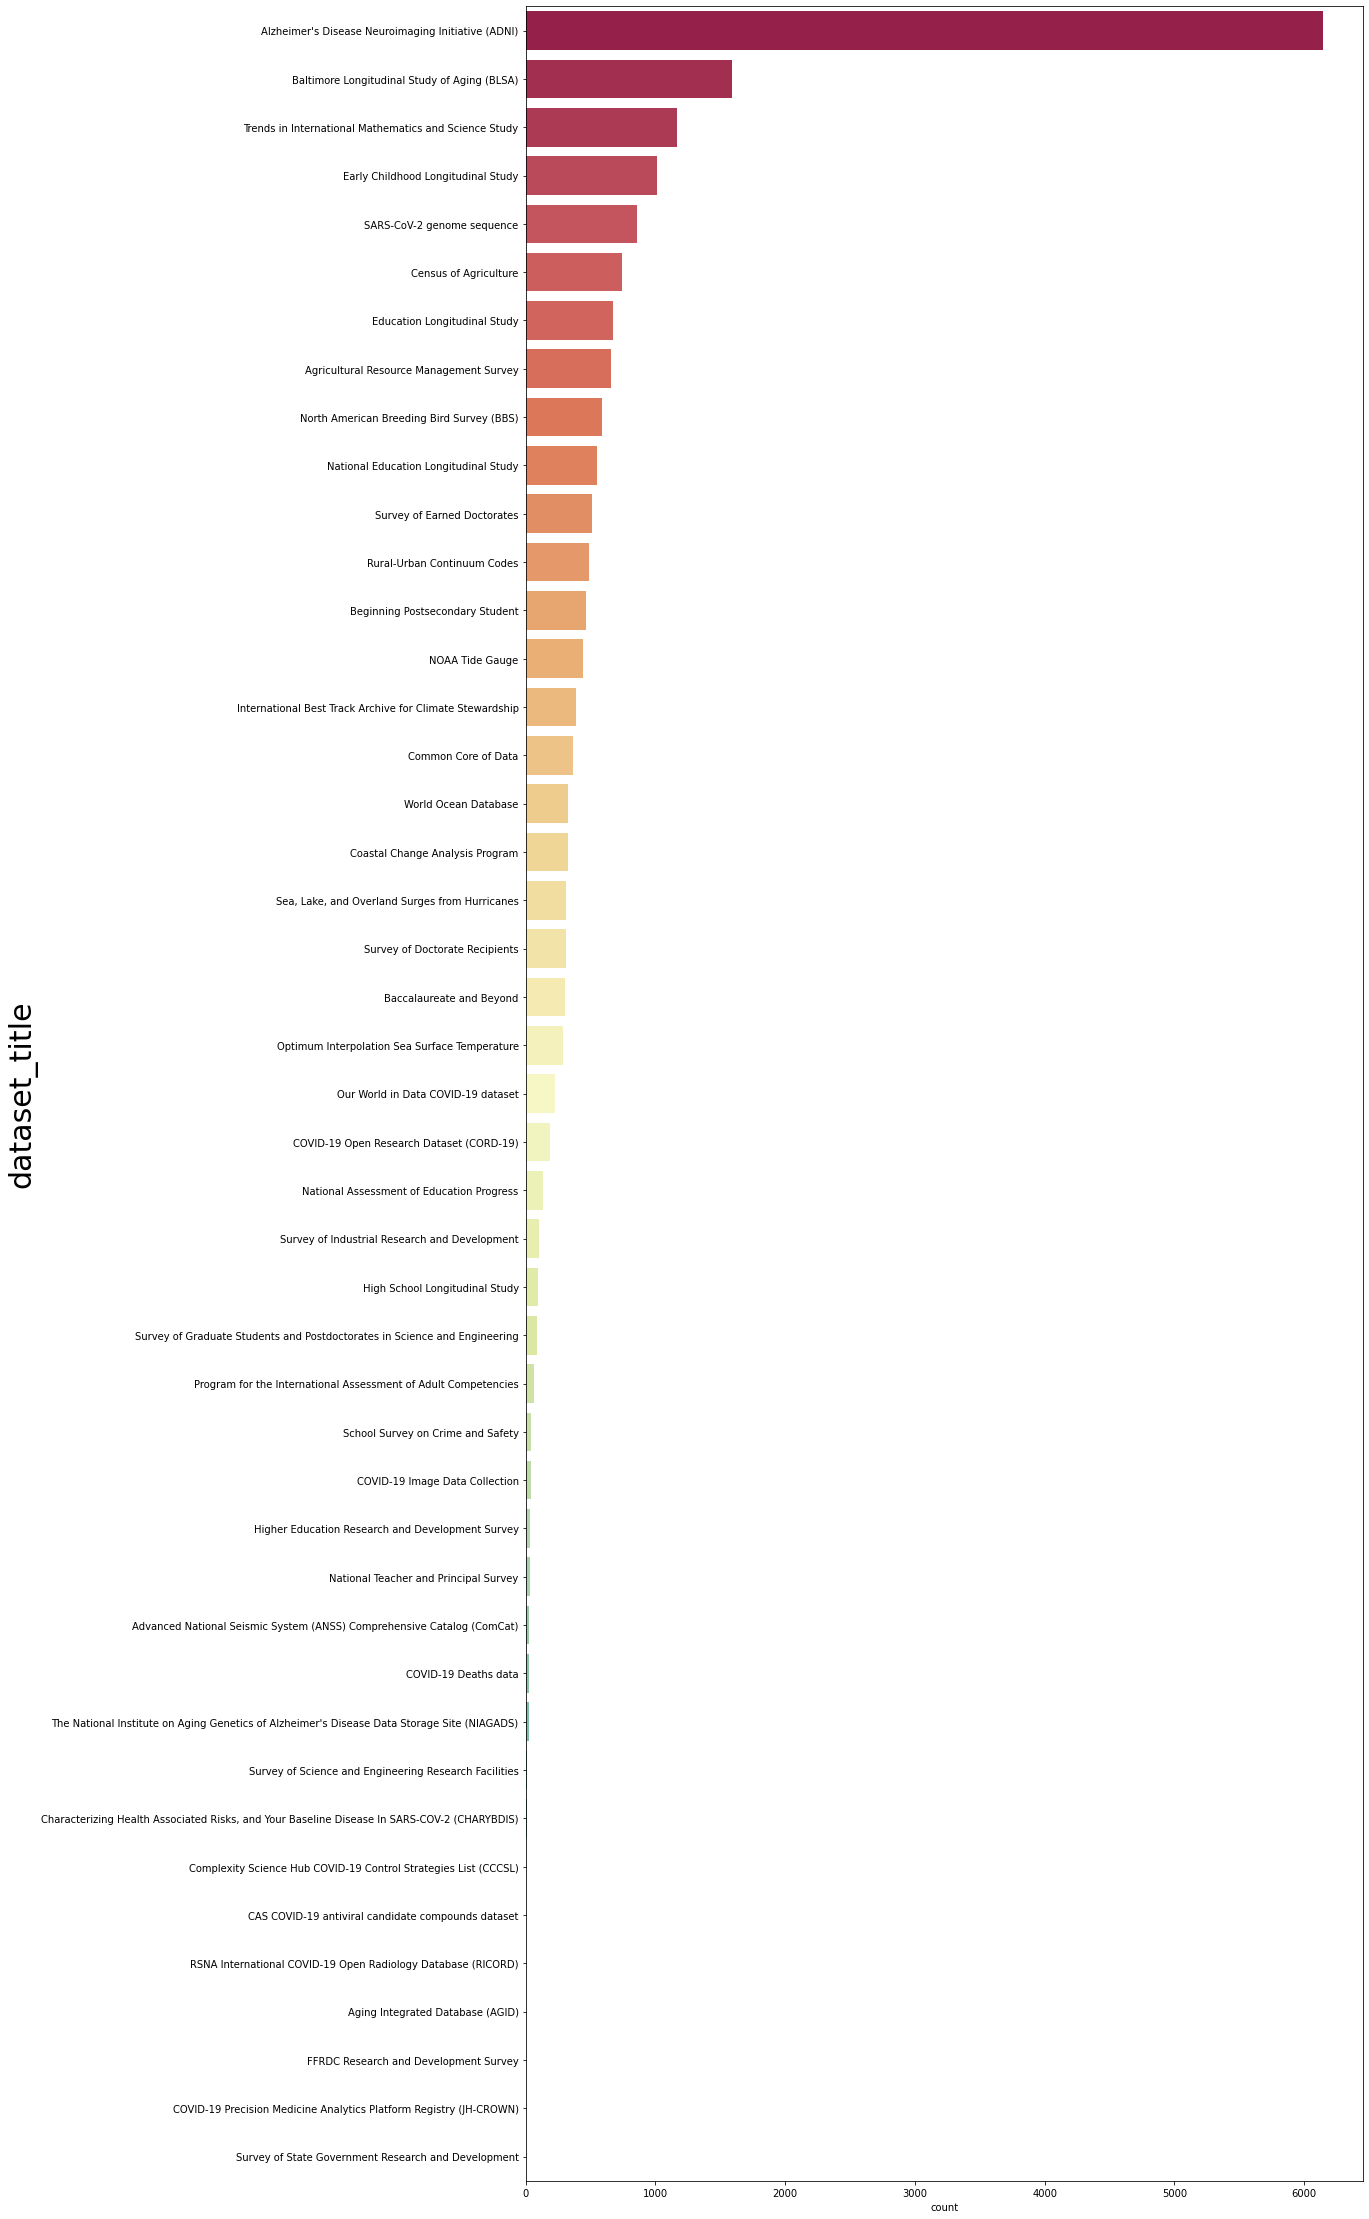

<Figure size 432x288 with 0 Axes>

In [38]:
plt.figure(figsize = (15, 40)),

sns.countplot(y = train_df['dataset_title'], 
              order = train_df['dataset_title'].value_counts().index, 
              palette = 'Spectral')
plt.ylabel('dataset_title',fontsize = 30)
plt.show()

#save
plt.savefig('dataset_title.png')

### 'dataset_label'

In [39]:
train_df['dataset_label'].unique()

array(['National Education Longitudinal Study', 'NOAA tidal station',
       'SLOSH model', 'NOAA C-CAP', 'Aging Integrated Database (AGID)',
       'Alzheimers Disease Neuroimaging Initiative',
       'Aging Integrated Database',
       'NOAA National Water Level Observation Network',
       'NOAA water level station',
       'Baltimore Longitudinal Study of Aging (BLSA)',
       'National Water Level Observation Network',
       'ARMS Farm Financial and Crop Production Practices',
       'Beginning Postsecondary Student',
       'NOAA Sea, Lake, and Overland Surges from Hurricanes',
       'NOAA Tide Gauge',
       "The National Institute on Aging Genetics of Alzheimer's Disease Data Storage Site",
       'National Center for Education Statistics Common Core of Data',
       'National Science Foundation Survey of Industrial Research and Development',
       'Baccalaureate and Beyond',
       'NOAA International Best Track Archive for Climate Stewardship',
       'Agricultural Resourc

In [40]:
train_df['dataset_label'].value_counts().head(20)

ADNI                                                     3673
Alzheimer's Disease Neuroimaging Initiative (ADNI)       2400
Trends in International Mathematics and Science Study    1163
Baltimore Longitudinal Study of Aging                    1156
Early Childhood Longitudinal Study                       1011
Education Longitudinal Study                              676
Census of Agriculture                                     643
Agricultural Resource Management Survey                   623
National Education Longitudinal Study                     550
Rural-Urban Continuum Codes                               490
Baltimore Longitudinal Study of Aging (BLSA)              433
Survey of Earned Doctorates                               428
North American Breeding Bird Survey                       380
World Ocean Database                                      314
SLOSH model                                               304
NOAA Tide Gauge                                           299
Survey o

### 'cleaned_label'

In [41]:
train_df['cleaned_label'].unique()

array(['national education longitudinal study', 'noaa tidal station',
       'slosh model', 'noaa c cap', 'aging integrated database agid ',
       'alzheimers disease neuroimaging initiative',
       'aging integrated database',
       'noaa national water level observation network',
       'noaa water level station',
       'baltimore longitudinal study of aging blsa ',
       'national water level observation network',
       'arms farm financial and crop production practices',
       'beginning postsecondary student',
       'noaa sea lake and overland surges from hurricanes',
       'noaa tide gauge',
       'the national institute on aging genetics of alzheimer s disease data storage site',
       'national center for education statistics common core of data',
       'national science foundation survey of industrial research and development',
       'baccalaureate and beyond',
       'noaa international best track archive for climate stewardship',
       'agricultural resource ma

In [42]:
train_df['cleaned_label'].value_counts().head(20)

adni                                                     3673
alzheimer s disease neuroimaging initiative adni         2400
trends in international mathematics and science study    1163
baltimore longitudinal study of aging                    1156
early childhood longitudinal study                       1011
education longitudinal study                              676
census of agriculture                                     643
agricultural resource management survey                   623
national education longitudinal study                     550
rural urban continuum codes                               490
baltimore longitudinal study of aging blsa                433
survey of earned doctorates                               428
north american breeding bird survey                       380
world ocean database                                      314
slosh model                                               304
noaa tide gauge                                           299
survey o

### Frequency Distributions

In [43]:
#create a frequency distribution to see which words are used the most
words = list( train_df['cleaned_label'].values)
stopwords = stopwords_list
split_words = []
for word in words:
    lo_w = []
    list_of_words = str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist
    
#get 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
mostcommon

[('adni', 6073),
 ('study', 5338),
 ('longitudinal', 4175),
 ('disease', 2503),
 ('neuroimaging', 2471),
 ('initiative', 2471),
 ('alzheimer', 2422),
 ('survey', 2365),
 ('aging', 1614),
 ('baltimore', 1589),
 ('education', 1447),
 ('international', 1338),
 ('science', 1316),
 ('trends', 1163),
 ('mathematics', 1163),
 ('early', 1011),
 ('childhood', 1011),
 ('national', 936),
 ('genome', 860),
 ('sars', 804),
 ('cov', 804),
 ('2', 804),
 ('census', 743),
 ('agriculture', 743),
 ('data', 686),
 ('agricultural', 647),
 ('management', 647),
 ('resource', 623),
 ('north', 585),
 ('american', 585),
 ('breeding', 585),
 ('bird', 585),
 ('world', 549),
 ('noaa', 548),
 ('earned', 509),
 ('doctorates', 509),
 ('rural', 490),
 ('urban', 490),
 ('continuum', 490),
 ('codes', 490),
 ('students', 476),
 ('sequences', 462),
 ('beginning', 461),
 ('postsecondary', 461),
 ('blsa', 433),
 ('sequence', 398),
 ('common', 368),
 ('core', 368),
 ('19', 362),
 ('research', 341),
 ('tide', 334),
 ('databas

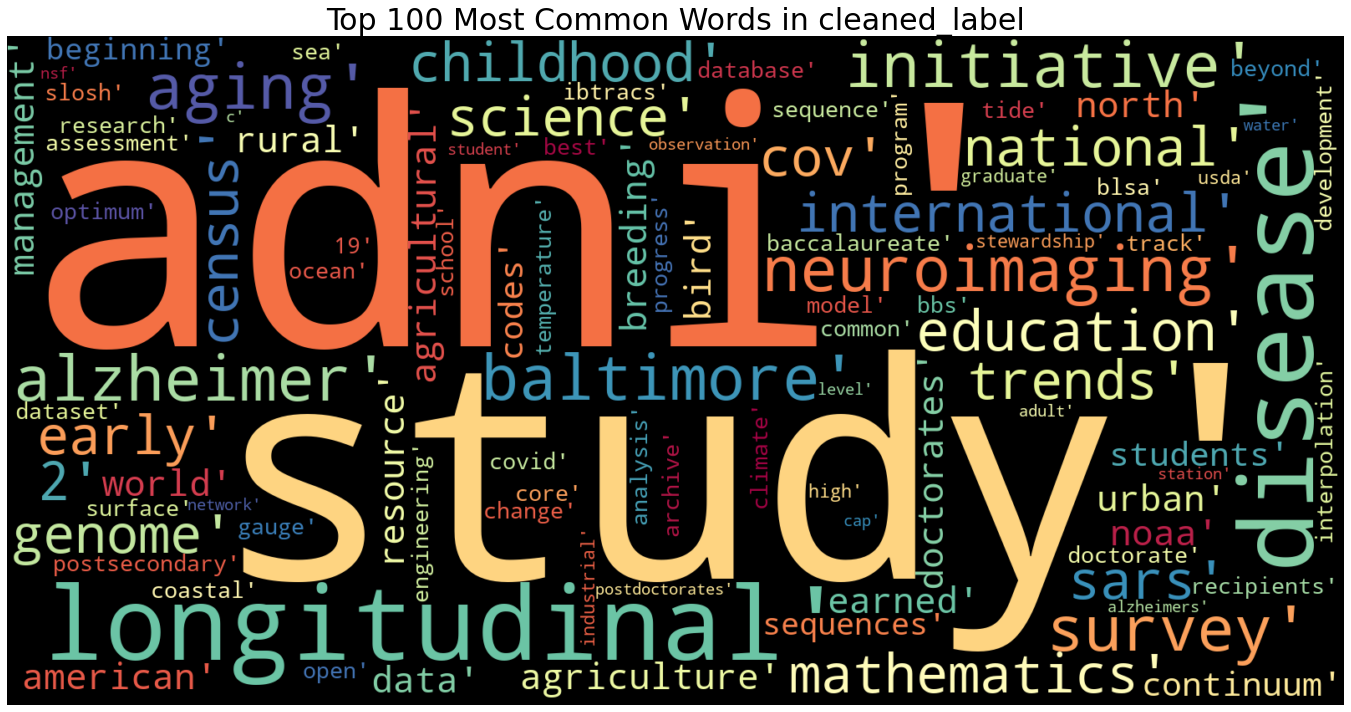

In [44]:
#plot frequency distributions
wordcloud = WordCloud(width = 1600, height = 800, 
                      background_color = 'black', 
                      colormap = 'Spectral', 
                      stopwords = stopwords_list).generate(str(mostcommon))

fig = plt.figure(figsize = (20, 10), facecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize = 30)
plt.tight_layout()

#save
plt.savefig('cleaned_label_top100_common_words.png')

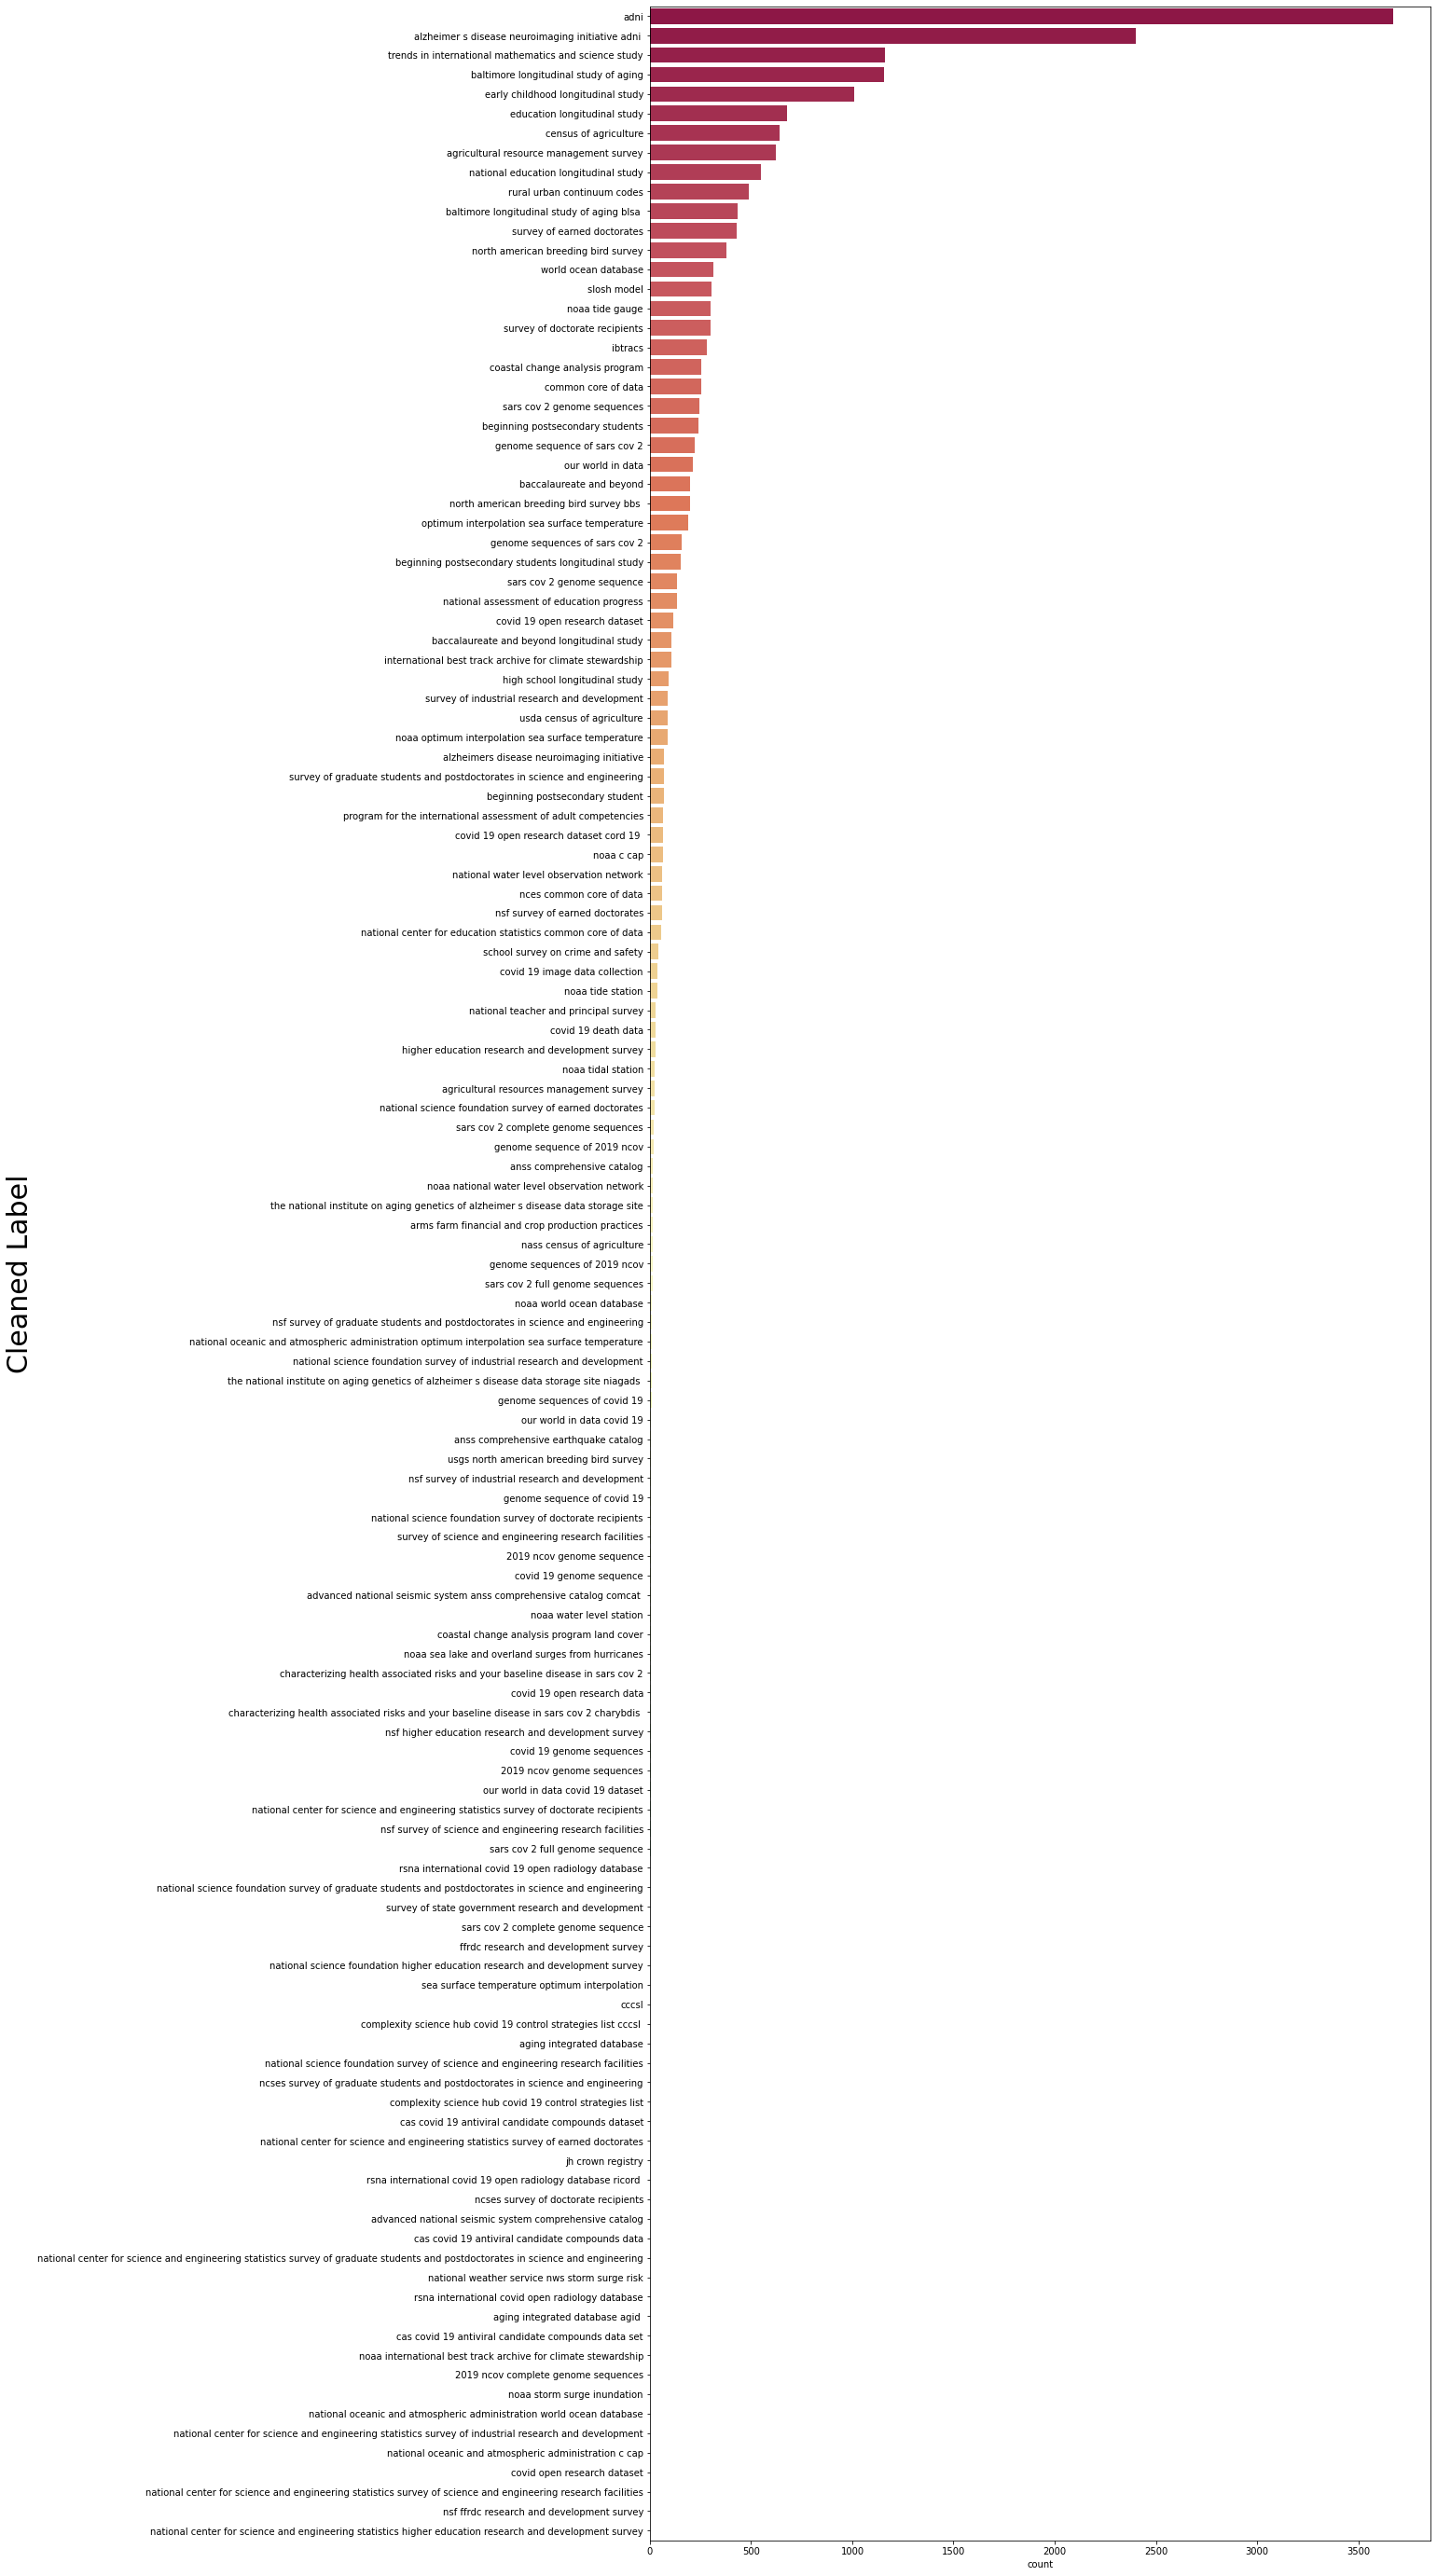

<Figure size 432x288 with 0 Axes>

In [45]:
plt.figure(figsize = (15, 50)),

sns.countplot(y = train_df['cleaned_label'], 
              order = train_df['cleaned_label'].value_counts().index, 
              palette = 'Spectral')
plt.ylabel('Cleaned Label',fontsize = 30)
plt.show()

#save
plt.savefig('cleaned_label.png')